# Some initial correlation analysis

In [1]:
import numpy as np
import pandas as pd
from itertools import product

import datetime as dt
import time

import os
from os import listdir
from os.path import isfile,join
import matplotlib.pyplot as plt

In [2]:
PATH = '/home/moni/Documents/motmo/timeSeries_files/' # original data
PATH2 = '/home/moni/Documents/motmo/data_without_hhID/' # folder in which we will store transformed data

### 1st Goal

I want to kinda transpose the dataframe and have the columns to be `emissions_X` and `stock_X`, where `X` can be replaced with
- `C`: combustion car
- `E`: electric car
- `N`: non-motorized.
- `P`: public transport.
- `S`: shared mobility.

In [3]:
hh_df = pd.read_csv(PATH2 + 'timeSeries_CH0SP1SE1WE0BP0RE0CO1DI0WO0CS0.csv')
hh_df

,Unnamed: 0,step,reID,emissions_C,emissions_E,emissions_N,emissions_P,emissions_S,stock_C,stock_E,stock_N,stock_P,stock_S,total_emissions
0,0,13,942,4.709517e+08,1.374278e+05,264.152610,2.643789e+07,4.598594e+05,37972,10,3366,5299,28,4.979871e+08
1,1,13,1515,2.665622e+09,1.298666e+06,1782.613067,2.333695e+08,1.988982e+06,222504,76,22756,47787,154,2.902281e+09
2,2,13,1516,1.660255e+09,4.425313e+05,1182.829551,1.025609e+08,6.580372e+05,137337,23,15343,21013,62,1.763917e+09
3,3,13,1517,9.376259e+08,3.791444e+05,611.480235,6.476010e+07,6.141000e+05,78239,23,7670,13429,44,1.003380e+09
4,4,13,1518,8.254569e+07,0.000000e+00,38.415312,6.042589e+06,2.680761e+04,7358,0,513,1376,2,8.861513e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2683,2683,180,2335,3.586460e+08,6.963521e+06,40.572440,2.750924e+07,6.798272e+05,32288,1251,446,7272,49,3.937986e+08
2684,2684,180,2336,6.203866e+08,1.677639e+07,88.334120,4.130009e+07,8.577773e+05,53581,3091,1034,11174,53,6.793210e+08
2685,2685,180,3312,2.668280e+08,4.439659e+06,38.190878,1.874227e+07,3.062764e+05,22657,779,390,4788,21,2.903162e+08
2686,2686,180,3562,4.664780e+08,1.567774e+07,89.412193,3.822309e+07,1.511763e+07,35094,2582,992,8730,1375,5.354966e+08


### Names of new columns
In the following code, we get the names of the columns for which we are going to calculate the "return" for each timestep and each of the variables (`emissions_X` and `stock_X`).

In [4]:
l1 = ["stepRet_"]
l2 = ["emi", "stck"]
l3 = ["C", "E", "N", "P", "S"]
return_colnames = list(" ".join(a + b + c for a, b, c in product(l1, l2, l3)).split(" "))


In [8]:
return_colnames

['stepRet_emiC',
 'stepRet_emiE',
 'stepRet_emiN',
 'stepRet_emiP',
 'stepRet_emiS',
 'stepRet_stckC',
 'stepRet_stckE',
 'stepRet_stckN',
 'stepRet_stckP',
 'stepRet_stckS']

## Timestep (Daily) Return

This term is taken from portfolio analysis, and it measures how good or bad a certain investment is behaving, for each timestep (usually in finance, it is measured in a *daily* basis). It is a ratio or percentage for each of the steps that we have data. Let $R_i$ be the "return" at step $i$, for $0\leq i\leq 180$, and let $P_i$ be the value given at step $i$. We define it recursively as follows:

$$R_i=\frac{P_i-P_{i-1}}{P_{i-1}}$$with $R_0=0$ (or `NaN` in our case).

For this model, for example, we measure the *return* on the emissions of combustion cars, that is, from the variable `emissions_C`. In this case, $P_i$ is the value at time $i$ of the column `emissions_C` (notice that we are for now ignoring the region ID, but we made a mask in the code, we just ignored it for simplicity in the notation).

In [5]:
def timeStep_returns(df, var_names):
    origNames = list(df.columns[3:-1]) # variable names of the original df
    df2 = df[['step', 'reID']] # create (almost) empty dataset
    # df2 = df2.groupby(['reID','step']).sum().reset_index()
    idList = list(df['reID'].unique()) # list of regions ids
    for RID in idList:
        mask = (df['reID'] == RID)
        for name, oname in zip(var_names, origNames):
            df2.loc[mask,name] = (df.loc[mask,oname] / df.loc[mask,oname].shift(1)) -1
    return df2

In [6]:
hh_df2 = timeStep_returns(hh_df, return_colnames)
# borrar3.loc[borrar3['reID']==942]

/home/moni/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1681: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = empty_value
/home/moni/anaconda3/lib/python3.9/site-packages/pandas/core/indexing.py:1773: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(ilocs[0], value, pi)


In [7]:
hh_df2

,step,reID,stepRet_emiC,stepRet_emiE,stepRet_emiN,stepRet_emiP,stepRet_emiS,stepRet_stckC,stepRet_stckE,stepRet_stckN,stepRet_stckP,stepRet_stckS
0,13,942,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,13,1515,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,13,1516,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,13,1517,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,13,1518,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...
2683,180,2335,-0.000544,0.039067,-0.011786,-0.003603,0.000000,-0.000959,0.044240,-0.013274,-0.002195,0.00000
2684,180,2336,-0.000541,0.025454,-0.007675,-0.003086,0.000000,-0.000802,0.029304,-0.009579,-0.003122,0.00000
2685,180,3312,-0.000116,0.041283,-0.011426,-0.004308,0.000000,-0.000529,0.041444,-0.010152,-0.003123,0.00000
2686,180,3562,-0.000332,0.011454,-0.001719,-0.003966,0.016966,-0.000484,0.014140,-0.003015,-0.004107,0.01476


In [25]:
def plot_df(df,regID):# this one already has the returns
    df.index = df['step']
    mask = (df['reID'] == regID)
    # only plot data from a region and a certain variable (in this example,
    # `emissions_C`)
    df_sub1 = df[['emissions_C','emissions_E']].loc[mask]
    # df_sub2 = df['stepRet_emiE'].loc[mask].to_frame()
    
    # df_sub1.plot(x ='step', y='stepRet_emiC', kind = 'line')
    # df_sub1.plot(x ='step', y='stepRet_emiE', kind = 'line')
    # plt.show()
    
    plt.figure()
    fig = df_sub1.plot(figsize=(9,6), title = "Emissions combustion vs electric cars")
    fig.axes.title.set_size(12)
    
    

<Figure size 432x288 with 0 Axes>

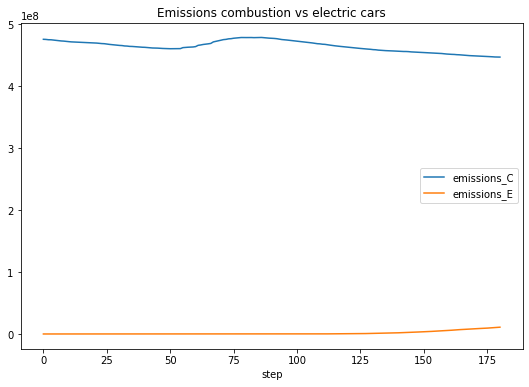

In [26]:
# hh_df2[['stepRet_emiC','stepRet_emiE']].loc[hh_df['reID']==942]
# hh_df.loc[hh_df['reID']==942]
plot_df(hh_df,942)